# Imports

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter

from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('../dataset/datasetX.csv', encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
data.shape

(1599999, 6)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1599999 non-null  int64 
 1   time      1599999 non-null  int64 
 2   date      1599999 non-null  object
 3   query     1599999 non-null  object
 4   username  1599999 non-null  object
 5   text      1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
np.sum(data.isnull().any(axis=1))

0

In [8]:
data=data[['text','label']]

In [9]:
data['label'][data['label']==4]=1

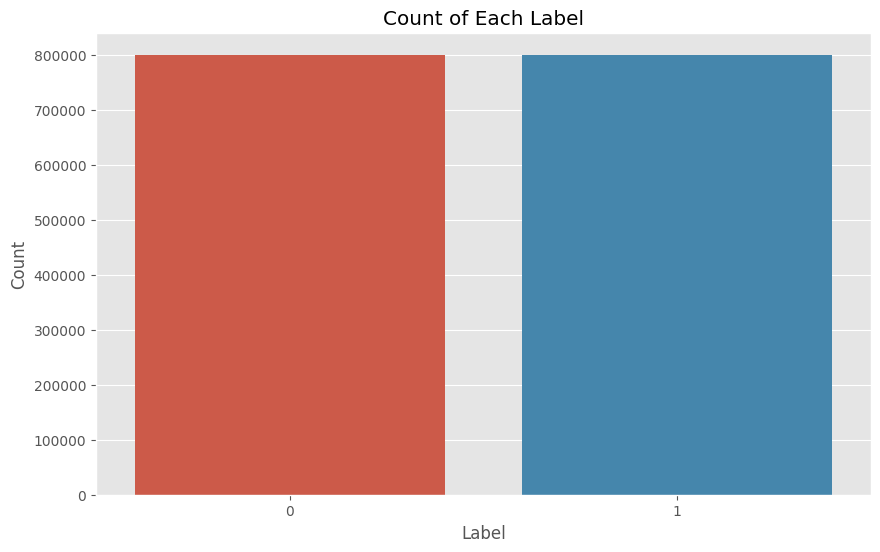

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=data)
plt.title('Count of Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [11]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]
data = pd.concat([data_pos, data_neg])

In [12]:
import sys
sys.path.append('../')
from tokenizer import tokenization
from processing import processing

data = processing.applyPreprocessing(data)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
X=data["text"]
y=data["label"]

In [14]:
max_len = 500
num_words = 2000
tokenizer = tokenization.createTokenizer(X, '../tokenizer/tokenizer.pkl', num_words)

def ConvertTextToArray(data, tokenizer):
    sequences = tokenizer.texts_to_sequences(data)
    return sequence.pad_sequences(sequences,maxlen=max_len)

In [15]:
sequences_matrix = ConvertTextToArray(X, tokenizer)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [17]:
def tensorflow_based_model(): 
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs) 
    layer = LSTM(64)(layer) 
    layer = Dense(256,name='FC1')(layer) 
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer) 
    layer = Dense(1,name='out_layer')(layer) 
    layer = Activation('sigmoid')(layer) 
    model = Model(inputs=inputs,outputs=layer) 
    return model 

In [18]:
model = tensorflow_based_model() 
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])  
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)
print('Training finished !!')


Epoch 1/6


118/315 [==========>...................] - ETA: 3:12 - loss: 0.6881 - accuracy: 0.5494

In [ ]:
accr1 = model.evaluate(X_test,Y_test) 
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) 

In [ ]:
y_pred = model.predict(X_test) 
y_pred = (y_pred > 0.5) 

In [ ]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import lime
import lime.lime_text

tok = tokenization.getTokenizer( '../tokenizer/tokenizer.pkl')
def predict_sentiment(data):
    sequences = tok.texts_to_sequences(data)

    sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

    predictions = model.predict(sequences_matrix)
    if predictions.shape[1] == 1:
        predictions = np.hstack([1 - predictions, predictions])
    
    return predictions



np.random.seed(42)  
sample_indices = np.random.choice(len(X), size=10, replace=False) 


for tweet_index in sample_indices:
    tweet_text = X.iloc[tweet_index]
    text_to_explain = [' '.join(tweet_text)] 
    print(text_to_explain)    

    print('---------------------------------------')

    explainer = lime.lime_text.LimeTextExplainer(class_names=['negative', 'positive'])
    exp = explainer.explain_instance(text_to_explain[0], predict_sentiment, num_features=10)


    exp.show_in_notebook(text=True)


    exp.save_to_file(f'lime_explanation_{tweet_index}.html')